In [5]:
from example_utils import *
!rm -rf train_ridge_model
!rm -rf cv/*

In [6]:
import numpy as np
from sklearn.linear_model import Ridge
from digital_experiments import experiment

N = 50
np.random.seed(2)
X = np.random.rand(N, 2) * 10
y = 2 * X[:, 0] + X[:, 1] + 3 + np.random.randn(N)


@experiment(verbose=False)
def train_ridge_model(alpha, fit_intercept, fold=0, k=10):
    
    # cross validation: hold out 1/k of the data
    test = np.arange(N) % k == fold
    train = ~test

    # train model
    model = Ridge(alpha=alpha, fit_intercept=fit_intercept)
    model.fit(X[train], y[train])

    yhat = model.predict(X)
    absolute_errors = np.abs(yhat - y)

    return {
        "mae": {
            "train": absolute_errors[train].mean(),
            "test": absolute_errors[test].mean(),
        }
    }

In [7]:
from digital_experiments.util import summarise

@experiment(save_to="cv/train_ridge_model", backend="json")
def cv_train(alpha, fit_intercept):
    results = []
    for f in range(10):
        results.append(train_ridge_model(alpha, fit_intercept, fold=f, k=10))
    return summarise(results, agg_fns=[np.mean, np.std])

In [8]:
from digital_experiments import optimize_step_for, Real, Categorical

space = {
    "alpha": Real(1e-1, 1e3, prior="log-uniform"),
}

random_points = 5
opt_points = 7

for i in range(random_points + opt_points):
    optimize_step_for(
        cv_train, 
        loss_fn=lambda results: results['mae']['train']['mean'], 
        n_random_points=random_points, 
        space=space,
        root="cv/train_ridge_model",
        config_overides={"fit_intercept": True},
    )

In [9]:
from digital_experiments import all_experiments_matching

df, experiments = all_experiments_matching("cv/train_ridge_model")
dict(df.sort_values("mae.train.mean").iloc[0])

{'experiment_number': 8,
 'alpha': 14.63914118456675,
 'fit_intercept': True,
 'mae.train.mean': 0.7877347999992846,
 'mae.train.std': 0.04073620583711054,
 'mae.test.mean': 0.8437848879220533,
 'mae.test.std': 0.380512338950564}

In [11]:
all_experiments_matching("cv/train_ridge_model", include_metadata=True)[0]

,experiment_number,alpha,fit_intercept,mae.train.mean,mae.train.std,mae.test.mean,mae.test.std,_time.start,_time.end,_context
0,0,100.000000,True,1.348711,0.036199,1.407732,0.429354,1.668600e+09,1.668600e+09,random-search
1,1,1.000000,True,0.823336,0.040023,0.890304,0.313097,1.668600e+09,1.668600e+09,random-search
2,2,0.316228,True,0.826470,0.040024,0.894533,0.309269,1.668600e+09,1.668600e+09,random-search
3,3,10.000000,True,0.792452,0.040156,0.848527,0.358176,1.668600e+09,1.668600e+09,random-search
4,4,0.100000,True,0.827487,0.040002,0.895874,0.308069,1.668600e+09,1.668600e+09,random-search
5,5,7.191374,True,0.799923,0.039599,0.857338,0.346488,1.668600e+09,1.668600e+09,bayesian-optimization
6,6,2.882068,True,0.815199,0.039839,0.878773,0.323869,1.668600e+09,1.668600e+09,bayesian-optimization
7,7,6.150350,True,0.803158,0.039632,0.860673,0.342271,1.668600e+09,1.668600e+09,bayesian-optimization
8,8,14.639141,True,0.787735,0.040736,0.843785,0.380512,1.668600e+09,1.668600e+09,bayesian-optimization
9,9,0.167548,True,0.827165,0.040013,0.895455,0.308443,1.668600e+09,1.668600e+09,bayesian-optimization



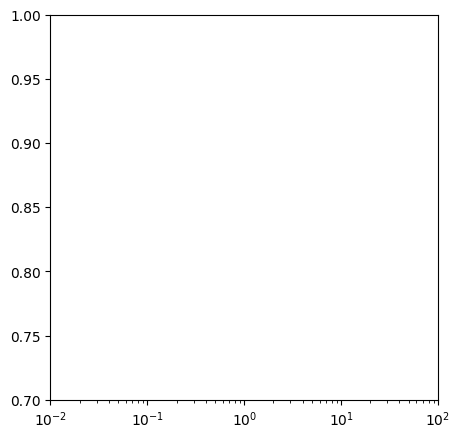

<Figure size 500x500 with 0 Axes>

In [12]:
from digital_experiments.plots import gif
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [5, 5]

intercepts = df[df.fit_intercept]
def plot(i):
    plt.scatter(intercepts.alpha[:i], intercepts["mae.test.mean"][:i], alpha=0.5)
    plt.xscale("log")
    plt.xlim(1e-2, 1e2)
    plt.ylim(0.7, 1.0)

gif(plot, range(len(intercepts)), "intercepts.gif", fps=2)